In [1]:
#Kaggle Dataset : "thedagger/pokemon-generation-one"
import kagglehub
path = kagglehub.dataset_download("thedagger/pokemon-generation-one")

print("Datatset Path : ", path)

100%|██████████| 2.15G/2.15G [00:55<00:00, 41.9MB/s]

Extracting files...


Datatset Path :  /root/.cache/kagglehub/datasets/thedagger/pokemon-generation-one/versions/1


In [5]:
!ls /root/.cache/kagglehub/datasets/thedagger/pokemon-generation-one/versions/1/dataset

Abra	    Diglett	Golbat	    Kingler    Nidoqueen  Psyduck    Tauros
Aerodactyl  Ditto	Goldeen     Koffing    Nidorina   Raichu     Tentacool
Alakazam    Dodrio	Golduck     Krabby     Nidorino   Rapidash   Tentacruel
Arbok	    Doduo	Golem	    Lapras     Ninetales  Raticate   Vaporeon
Arcanine    Dragonair	Graveler    Lickitung  Oddish	  Rattata    Venomoth
Articuno    Dragonite	Grimer	    Machamp    Omanyte	  Rhydon     Venonat
Beedrill    Dratini	Growlithe   Machoke    Omastar	  Rhyhorn    Venusaur
Bellsprout  Drowzee	Gyarados    Machop     Onix	  Sandshrew  Victreebel
Blastoise   Dugtrio	Haunter     Magikarp   Paras	  Sandslash  Vileplume
Bulbasaur   Eevee	Hitmonchan  Magmar     Parasect   Scyther    Voltorb
Butterfree  Ekans	Hitmonlee   Magnemite  Persian	  Seadra     Vulpix
Caterpie    Electabuzz	Horsea	    Magneton   Pidgeot	  Seaking    Wartortle
Chansey     Electrode	Hypno	    Mankey     Pidgeotto  Seel	     Weedle
Charizard   Exeggcute	Ivysaur     Marowak    Pidgey	  Shellder   

In [8]:
import os
from collections import Counter

data_dir = "/root/.cache/kagglehub/datasets/thedagger/pokemon-generation-one/versions/1/dataset" #Base Kagglee Dataset
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Dataset not found at {data_dir}")

classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f"Number of classes: {len(classes)}")

class_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    class_counts[cls] = num_images

print("\nSample class distribution:")
for cls, count in list(class_counts.items()):
    print(f"{cls}: {count} images")

total_images = sum(class_counts.values())
print(f"\nTotal images in dataset: {total_images}")

Number of classes: 150

Sample class distribution:
Krabby: 64 images
Tentacool: 57 images
Mew: 67 images
Fearow: 122 images
Pidgeotto: 63 images
Magikarp: 59 images
Caterpie: 49 images
Nidoqueen: 65 images
Beedrill: 53 images
Hitmonlee: 65 images
Gloom: 58 images
Ninetales: 74 images
Machoke: 51 images
Weezing: 63 images
Drowzee: 60 images
Lapras: 71 images
Slowbro: 63 images
Clefairy: 60 images
Weepinbell: 51 images
Geodude: 56 images
Hitmonchan: 61 images
Jynx: 59 images
dataset: 0 images
Clefable: 49 images
Blastoise: 62 images
Farfetchd: 64 images
Raticate: 70 images
Chansey: 58 images
Meowth: 70 images
Mankey: 72 images
Metapod: 65 images
Pinsir: 63 images
Arcanine: 61 images
Omanyte: 55 images
Butterfree: 66 images
Parasect: 53 images
Nidorino: 63 images
Kingler: 68 images
Ivysaur: 53 images
Seaking: 65 images
Growlithe: 68 images
Nidorina: 59 images
Poliwrath: 63 images
Marowak: 70 images
Pikachu: 296 images
Vileplume: 67 images
Jolteon: 64 images
Psyduck: 159 images
Rhyhorn: 69

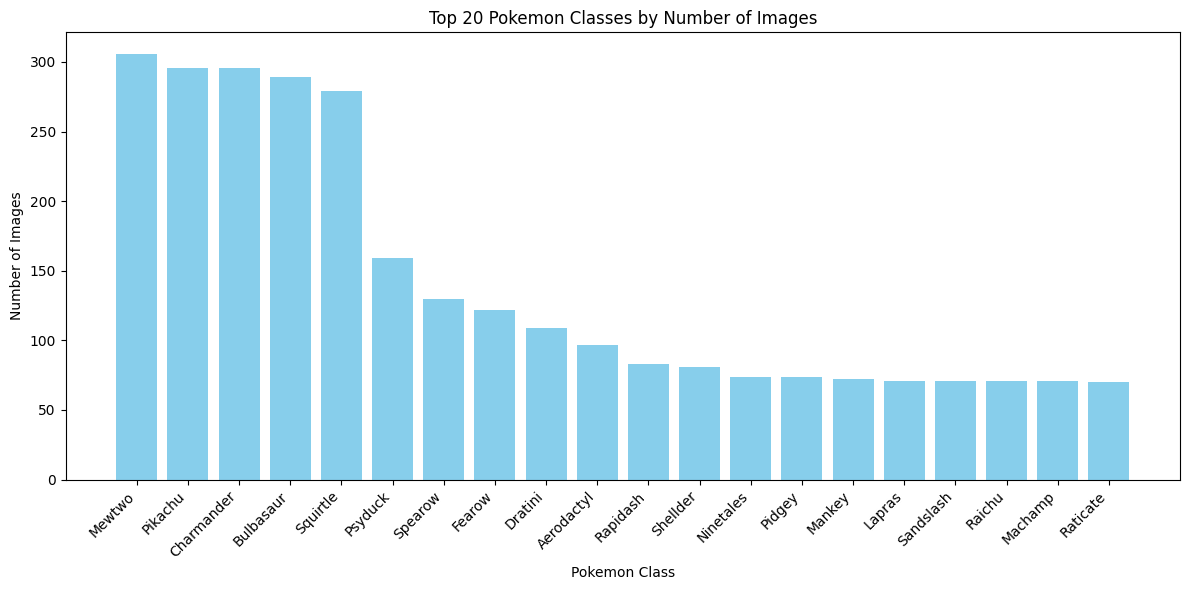

In [12]:
import matplotlib.pyplot as plt

top_classes = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:20])

plt.figure(figsize=(12,6))
plt.bar(top_classes.keys(), top_classes.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')  # rotate class names
plt.xlabel('Pokemon Class')
plt.ylabel('Number of Images')
plt.title('Top 20 Pokemon Classes by Number of Images')
plt.tight_layout()
plt.show()

In [15]:
#Data Prep
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision import datasets, transforms

data_dir = "/root/.cache/kagglehub/datasets/thedagger/pokemon-generation-one/versions/1/dataset"

In [30]:
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_counts = {}

for cls in classes:
    class_path = os.path.join(data_dir, cls)
    num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    if num_images > 0:
        class_counts[cls] = num_images

print(f"Number of non-empty classes: {len(class_counts)}")

Number of non-empty classes: 149


In [31]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [32]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

In [33]:
valid_class_names = list(class_counts.keys())

# Filter samples
filtered_samples = [s for s in full_dataset.samples if full_dataset.classes[s[1]] in valid_class_names]

# Rebuild class_to_idx
new_class_to_idx = {cls_name: i for i, cls_name in enumerate(valid_class_names)}

# Update dataset attributes
full_dataset.samples = [(fp, new_class_to_idx[full_dataset.classes[idx]]) for fp, idx in filtered_samples]
full_dataset.targets = [s[1] for s in full_dataset.samples]
full_dataset.classes = valid_class_names
full_dataset.class_to_idx = new_class_to_idx

num_classes = len(full_dataset.classes)
print(f"Number of classes after filtering empty folders: {num_classes}")
print(f"Total images after filtering: {len(full_dataset)}")

Number of classes after filtering empty folders: 149
Total images after filtering: 10657


In [34]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Apply test transforms to test dataset
test_dataset.dataset.transform = test_transform

In [35]:
train_targets = [full_dataset.targets[i] for i in train_dataset.indices]

# Compute counts array for non-empty classes
counts_array = np.array([class_counts[cls] for cls in full_dataset.classes])

# Sample weights: inverse of class counts
samples_weight = [1.0 / counts_array[t] for t in train_targets]

sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

In [36]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 8525
Test dataset size: 2132


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self, num_classes=150):
        super(DeepCNN, self).__init__()

        # --- Convolutional blocks ---
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128 -> 64x64
            nn.Dropout(0.1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 -> 32x32
            nn.Dropout(0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16
            nn.Dropout(0.3)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
            nn.Dropout(0.4)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8 -> 4x4
            nn.Dropout(0.5)
        )

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(512*4*4, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCNN(num_classes=150).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

DeepCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )


In [42]:
import torch
from torch import nn, optim
from sklearn.metrics import f1_score, accuracy_score
import copy

# -----------------------------
# Hyperparameters
# -----------------------------
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Training function
# -----------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    # Logs for plotting later
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "val_f1": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-"*30)

        # ---- Training Phase ----
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)

        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        # ---- Validation Phase ----
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = accuracy_score(val_labels, val_preds)
        val_epoch_f1 = f1_score(val_labels, val_preds, average="macro")

        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, Val F1: {val_epoch_f1:.4f}")
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc)
        history["val_f1"].append(val_epoch_f1)

        # ---- Save best model ----
        if val_epoch_f1 > best_f1:
            best_f1 = val_epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            print("Best model updated!")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [43]:
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=30,
    device=device
)


Epoch 1/30
------------------------------
Train Loss: 5.0298, Train Acc: 0.0099


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.8278, Val Acc: 0.0103, Val F1: 0.0005
Best model updated!

Epoch 2/30
------------------------------
Train Loss: 4.8360, Train Acc: 0.0137


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.7011, Val Acc: 0.0197, Val F1: 0.0024
Best model updated!

Epoch 3/30
------------------------------
Train Loss: 4.7689, Train Acc: 0.0122


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.7668, Val Acc: 0.0117, Val F1: 0.0036
Best model updated!

Epoch 4/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.7245, Train Acc: 0.0144


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.6212, Val Acc: 0.0127, Val F1: 0.0019

Epoch 5/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.6942, Train Acc: 0.0144


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.6143, Val Acc: 0.0141, Val F1: 0.0019

Epoch 6/30
------------------------------
Train Loss: 4.6590, Train Acc: 0.0174


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.6021, Val Acc: 0.0164, Val F1: 0.0025

Epoch 7/30
------------------------------
Train Loss: 4.6497, Train Acc: 0.0189


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.5564, Val Acc: 0.0155, Val F1: 0.0039
Best model updated!

Epoch 8/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.6421, Train Acc: 0.0195


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.5479, Val Acc: 0.0169, Val F1: 0.0024

Epoch 9/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.6143, Train Acc: 0.0183


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.4868, Val Acc: 0.0295, Val F1: 0.0065
Best model updated!

Epoch 10/30
------------------------------
Train Loss: 4.5714, Train Acc: 0.0215


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.4119, Val Acc: 0.0342, Val F1: 0.0063

Epoch 11/30
------------------------------
Train Loss: 4.5459, Train Acc: 0.0211


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.4545, Val Acc: 0.0371, Val F1: 0.0107
Best model updated!

Epoch 12/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.5407, Train Acc: 0.0256


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.4244, Val Acc: 0.0286, Val F1: 0.0138
Best model updated!

Epoch 13/30
------------------------------
Train Loss: 4.5027, Train Acc: 0.0272


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.3516, Val Acc: 0.0319, Val F1: 0.0131

Epoch 14/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.4297, Train Acc: 0.0320


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.3153, Val Acc: 0.0450, Val F1: 0.0132

Epoch 15/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.4328, Train Acc: 0.0291


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.2670, Val Acc: 0.0450, Val F1: 0.0160
Best model updated!

Epoch 16/30
------------------------------
Train Loss: 4.3772, Train Acc: 0.0358


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.2140, Val Acc: 0.0553, Val F1: 0.0247
Best model updated!

Epoch 17/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.3324, Train Acc: 0.0366


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.1899, Val Acc: 0.0568, Val F1: 0.0272
Best model updated!

Epoch 18/30
------------------------------
Train Loss: 4.2887, Train Acc: 0.0428


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.1157, Val Acc: 0.0783, Val F1: 0.0356
Best model updated!

Epoch 19/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.2072, Train Acc: 0.0524


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 4.0055, Val Acc: 0.0704, Val F1: 0.0365
Best model updated!

Epoch 20/30
------------------------------
Train Loss: 4.1302, Train Acc: 0.0602


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.9238, Val Acc: 0.0849, Val F1: 0.0503
Best model updated!

Epoch 21/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 4.0508, Train Acc: 0.0699


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.8615, Val Acc: 0.0765, Val F1: 0.0479

Epoch 22/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.9779, Train Acc: 0.0809


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.8030, Val Acc: 0.0957, Val F1: 0.0632
Best model updated!

Epoch 23/30
------------------------------
Train Loss: 3.9256, Train Acc: 0.0839


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.7660, Val Acc: 0.0990, Val F1: 0.0716
Best model updated!

Epoch 24/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.8633, Train Acc: 0.0956


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.7047, Val Acc: 0.1210, Val F1: 0.0951
Best model updated!

Epoch 25/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.7762, Train Acc: 0.1139


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.6161, Val Acc: 0.1243, Val F1: 0.0986
Best model updated!

Epoch 26/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.7144, Train Acc: 0.1147


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.4993, Val Acc: 0.1773, Val F1: 0.1227
Best model updated!

Epoch 27/30
------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.6417, Train Acc: 0.1282


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.4662, Val Acc: 0.1651, Val F1: 0.1274
Best model updated!

Epoch 28/30
------------------------------
Train Loss: 3.5861, Train Acc: 0.1389


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.4403, Val Acc: 0.1689, Val F1: 0.1364
Best model updated!

Epoch 29/30
------------------------------
Train Loss: 3.5244, Train Acc: 0.1479


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.3604, Val Acc: 0.1787, Val F1: 0.1498
Best model updated!

Epoch 30/30
------------------------------
Train Loss: 3.4317, Train Acc: 0.1636


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 3.3445, Val Acc: 0.1745, Val F1: 0.1509
Best model updated!


In [44]:
torch.save(trained_model.state_dict(), "alpha.h5")
print("Model saved as alpha.h5")

Model saved as alpha.h5


In [ ]:
#For Training More
model = DeepCNN(num_classes=150)
model.load_state_dict(torch.load("alpha.h5"))
model.to(device)
model.eval()

<Figure size 640x480 with 0 Axes>

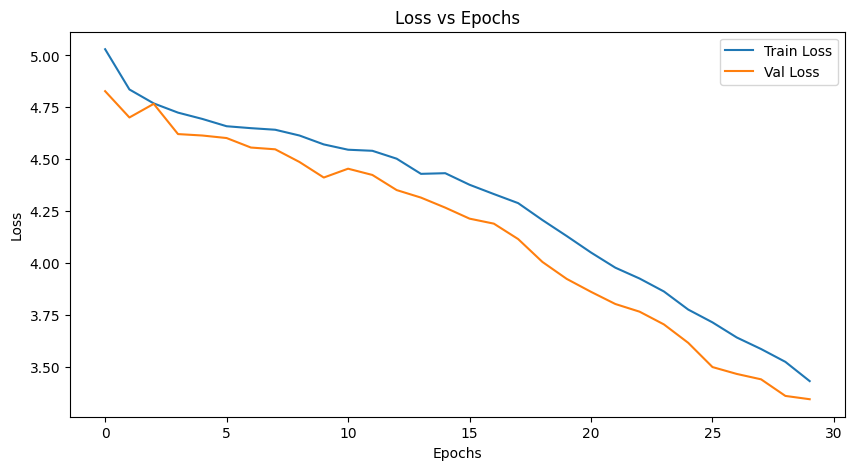

<Figure size 640x480 with 0 Axes>

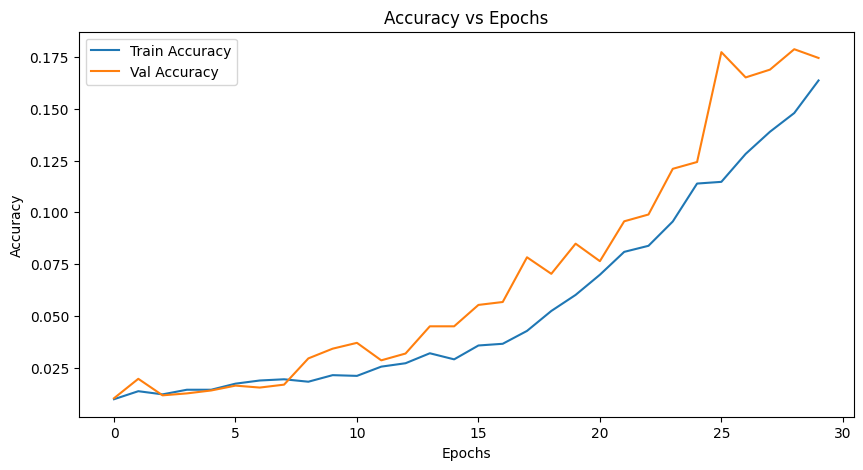

<Figure size 640x480 with 0 Axes>

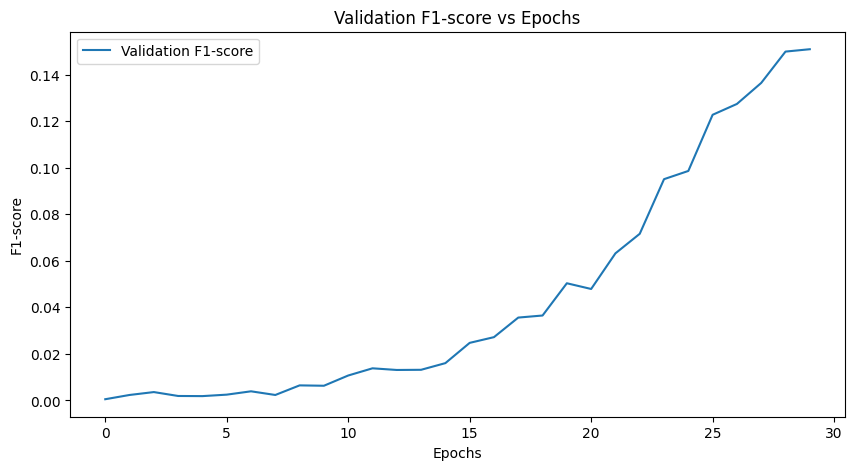

In [46]:
import matplotlib.pyplot as plt

# Clear figure before plotting
plt.clf()  # clears the current figure
plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(10,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(10,5))
plt.plot(history["val_f1"], label="Validation F1-score")
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.title("Validation F1-score vs Epochs")
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore")

trained_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # or validation loader
        images, labels = images.to(device), labels.to(device)
        outputs = trained_model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_acc = accuracy_score(all_labels, all_preds)
final_f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Final Accuracy: {final_acc:.4f}")
print(f"Final Macro F1-score: {final_f1:.4f}")

Final Accuracy: 0.1745
Final Macro F1-score: 0.1509


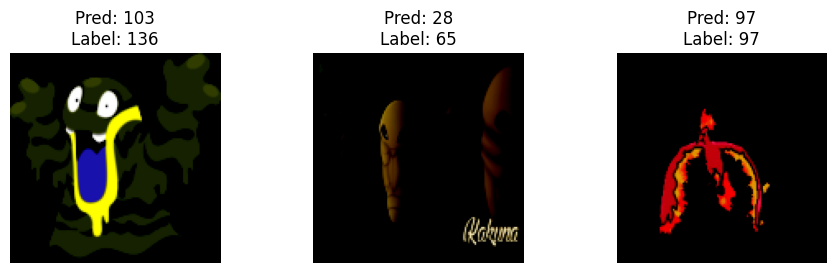

In [49]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings("ignore")

# Example: show 8 test images
trained_model.eval()
test_iter = iter(test_loader)
images, labels = next(test_iter)

images, labels = images.to(device), labels.to(device)
outputs = trained_model(images)
preds = torch.argmax(outputs, dim=1)

# Convert images to numpy for plotting
images = images.cpu().permute(0,2,3,1).numpy()

plt.figure(figsize=(15,6))
for i in range(3):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title(f"Pred: {preds[i].item()}\nLabel: {labels[i].item()}")
    plt.axis('off')
plt.show()